## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


# **SOLUCIÓN**

**Librerias**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

**Acceso a Drive**

Establecer sistema de archivos

In [0]:
from google.colab import drive
from os import chdir
    
drive.mount('/content/drive/', force_remount=True)
chdir("/content/drive/My Drive/evaluacion-felondonoa")

Mounted at /content/drive/


# **1. DATOS**

**Procesamiento de datos serie original**

Se reunen los archivos fuentes teniendo en cuenta las diferencias que presenta el cojuinto de datos.



In [0]:
df_conjuntoDatos = {}
for anualidad in range(1995, 2016):
    df_conjuntoDatos[str(anualidad)] = pd.read_excel(f'./datos/precios/Precio_Bolsa_Nacional_($kwh)_{anualidad}.xlsx')

for anualidad in range(2016, 2019):
    df_conjuntoDatos[str(anualidad)] = pd.read_excel(f'./datos/precios/Precio_Bolsa_Nacional_($kwh)_{anualidad}.xls')

df_conjuntoDatos.keys()

dict_keys(['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'])

Definición de funciones para la preparación de los datos en las que se eliminan las filas inválidas en el conjunto de datos, se nombran las columnas y se eliminan filas duplicadas.

Se define función para optener el promedio por fecha de kwh

In [0]:
def preprocessing_columnsname_duplicates(df_y, year):
    df = df_y.copy()
    
    df.columns = [f'col{i}' for i in range(len(df.columns))]

    # renombrar las columnas del dataframe
    columns = np.squeeze(df.loc[df[df.columns[0]] == 'Fecha'].values)
    lindex = int(df.loc[df[df.columns[0]] == 'Fecha'].index.values) + 1
    df.columns = columns
    # eliminar las filas primeras filas inválidas
    df = df.drop(list(range(0, lindex)))
    df = df.dropna()
    
    # eliminar filas duplicadas
    shp_old = df.shape[0]
    df = df.drop_duplicates()
    print(f'Dataframe {year}, Final shape: {df.shape}, duplicates: {shp_old - df.shape[0]}')

    return df


def generate_average_kWh(df_y):
    # Calcular promedio de los kWh
    df = pd.DataFrame()
    df['Fecha'] = df_y['Fecha']
    df['Mean'] = df_y.mean(axis=1)
    return df

def plot_prices(X, ext=''):
    plt.figure(figsize=(16,5))
    plt.title('Precio_Bolsa_Nacional_($kwh)' + ext)
    plt.xlabel('Días')
    plt.ylabel('kWh')
    plt.plot(X, color='blue')
    plt.show();

In [0]:
for anualidad in range(1995, 2019):
    anualidad = str(anualidad)
    df_conjuntoDatos[anualidad] = preprocessing_columnsname_duplicates(df_conjuntoDatos[anualidad], anualidad)
    df_conjuntoDatos[anualidad] = generate_average_kWh(df_conjuntoDatos[anualidad])

Dataframe 1995, Final shape: (164, 25), duplicates: 0
Dataframe 1996, Final shape: (366, 25), duplicates: 7
Dataframe 1997, Final shape: (365, 25), duplicates: 0
Dataframe 1998, Final shape: (365, 25), duplicates: 19
Dataframe 1999, Final shape: (365, 25), duplicates: 7
Dataframe 2000, Final shape: (366, 26), duplicates: 0
Dataframe 2001, Final shape: (365, 25), duplicates: 0
Dataframe 2002, Final shape: (365, 25), duplicates: 0
Dataframe 2003, Final shape: (365, 25), duplicates: 0
Dataframe 2004, Final shape: (366, 25), duplicates: 0
Dataframe 2005, Final shape: (365, 26), duplicates: 0
Dataframe 2006, Final shape: (365, 25), duplicates: 0
Dataframe 2007, Final shape: (365, 25), duplicates: 11
Dataframe 2008, Final shape: (366, 25), duplicates: 0
Dataframe 2009, Final shape: (365, 25), duplicates: 15
Dataframe 2010, Final shape: (365, 26), duplicates: 0
Dataframe 2011, Final shape: (365, 27), duplicates: 0
Dataframe 2012, Final shape: (366, 27), duplicates: 0
Dataframe 2013, Final sha

In [0]:
anualidades = sorted(list(df_conjuntoDatos))
df_juntos = pd.concat([df_conjuntoDatos[y] for y in anualidades], axis=0)
df_juntos.dropna()
parsed_dates = []

for fecha in df_juntos['Fecha'].values:
    if (isinstance(fecha,str)):
        parsed_dates.append(dt.datetime.strptime(fecha,"%Y-%m-%d"))
    elif (isinstance(fecha,dt.datetime)):
        parsed_dates.append(fecha)
    else:
        print(fecha)
        print(type(fecha))

df_juntos['Fecha2'] = pd.to_datetime(parsed_dates)
df_juntos['Timestamp'] = [d.timestamp() for d in parsed_dates]

df_juntos.to_csv('promedios.csv', index=False)
df_juntos.head()


,Fecha,Mean,Fecha2,Timestamp
3,1995-07-21,4.924333,1995-07-21,806284800.0
4,1995-07-22,1.269500,1995-07-22,806371200.0
5,1995-07-23,0.953083,1995-07-23,806457600.0
6,1995-07-24,4.305917,1995-07-24,806544000.0
7,1995-07-25,1.149167,1995-07-25,806630400.0


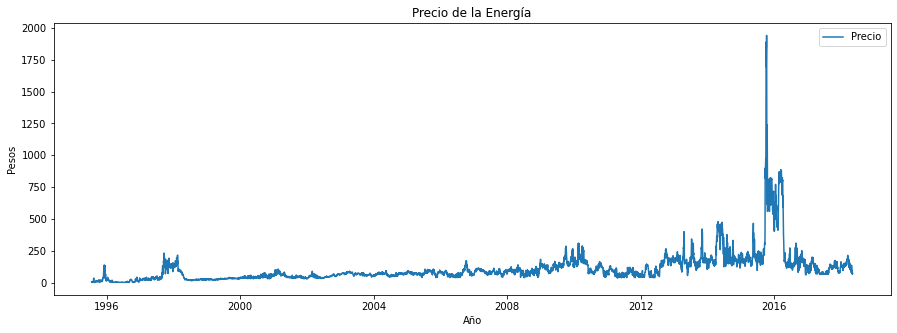

In [0]:
#plt.plot(df_juntos['Mean'].values)
df_juntos.sort_values(by='Fecha2')
plt.figure(figsize=(15,5))
plt.title('Precio de la Energía')
plt.xlabel('Año')
plt.ylabel('Pesos')
plt.plot(df_juntos['Fecha2'], df_juntos['Mean'],label="Precio")
plt.legend()


**Procesamiento de datos IPC**

In [0]:
df_IPC = pd.read_excel(f'./datos/precios/1.2.5.IPC_Serie_variaciones.xlsx', skiprows=12, parse_dates=True)
df_IPC = df_IPC.dropna(axis='index', thresh=2)
df_IPC = df_IPC.dropna(axis='columns', how='all')
df_IPC['Fecha2'] = [dt.datetime.strptime(str(date),"%Y%m") for date in df_IPC['Año(aaaa)-Mes(mm)'].tolist()]
df_IPC.sort_values(by='Fecha2', inplace=True)
df_IPC.tail()

,Año(aaaa)-Mes(mm),Índice,Inflación anual,Inflación mensual,Inflación año corrido,Fecha2
4,201910,103.43,0.0386,0.0016,0.0343,2019-10-01
3,201911,103.54,0.0384,0.0010,0.0354,2019-11-01
2,201912,103.80,0.0380,0.0026,0.0380,2019-12-01
1,202001,104.24,0.0362,0.0042,0.0042,2020-01-01
0,202002,104.94,0.0372,0.0067,0.0109,2020-02-01


In [0]:
base = (df_IPC['Índice'] == 103.43)
df_IPC_base = df_IPC.loc[base]
IPC_base = df_IPC_base['Índice'].tolist()[0]
print(IPC_base)

103.43


In [0]:
promedios_normalizados = []
for mes,dia in zip(df_juntos['Mean'].tolist(), df_juntos['Timestamp'].tolist()):
    date = dt.datetime.utcfromtimestamp(dia)
    base = (df_IPC['Fecha2'].dt.year == date.year) & (df_IPC['Fecha2'].dt.month == date.month)
    ipc = df_IPC.loc[base]['Índice'].values[0]
    precio_normalizado = mes * (IPC_base/ipc)
    promedios_normalizados.append(precio_normalizado)

df_juntos['Precio Normalizado'] = promedios_normalizados  

df_juntos.head()

,Fecha,Mean,Fecha2,Timestamp,Precio Normalizado
3,1995-07-21,4.924333,1995-07-21,806284800.0,24.334630
4,1995-07-22,1.269500,1995-07-22,806371200.0,6.273501
5,1995-07-23,0.953083,1995-07-23,806457600.0,4.709862
6,1995-07-24,4.305917,1995-07-24,806544000.0,21.278593
7,1995-07-25,1.149167,1995-07-25,806630400.0,5.678849


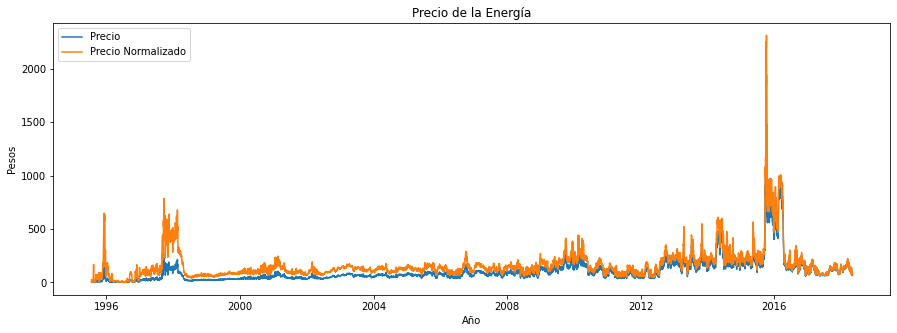

In [0]:
plt.figure(figsize=(15,5))
plt.title('Precio de la Energía')
plt.xlabel('Año')
plt.ylabel('Pesos')
plt.plot(df_juntos['Fecha2'], df_juntos['Mean'],label="Precio")
plt.plot(df_juntos['Fecha2'], df_juntos['Precio Normalizado'],label="Precio Normalizado")
plt.legend()

# **2. TRANSFORMACIÓN**

Transformaciones de Box-Cox arregla problemas de normalidad y heterocedasticidad (no homogeneidad de varianzas). En este caso es útil debido a que la serie de tiempo no presenta un varianza constante.

In [0]:
from sklearn.preprocessing import PowerTransformer

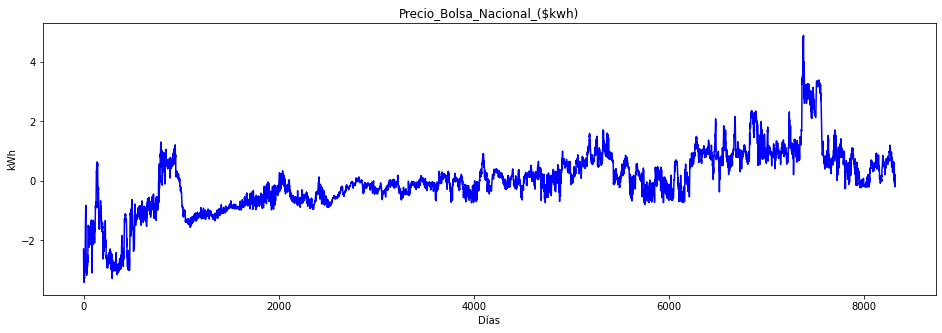

In [46]:
boxcox = PowerTransformer(method='box-cox')
x_transformed = boxcox.fit_transform(df_juntos['Mean'].values.reshape(-1, 1))
plot_prices(x_transformed)

# **3. MODELO**

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

In [0]:
class ADALINE(object):
    def __init__(self, L):
        self.w = tfe.Variable([0.0] * (L+1))

    def __call__(self, x):
        if type(x) is np.ndarray:
            x = tf.constant(np.concatenate(([1.0], x)), dtype=np.float32)
        else:
            x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

In [0]:
seed = 12345

# función a ser optimizada
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.square(error)


# registra todas las operaciones para aplicar posteriormente el gradiente
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.w])


# retorna la función de optimización a utilizar
def get_optimizer(mu, method='gradient', momentum=0.5):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=mu)
    if method == 'momentum':
        optimizer = tf.train.MomentumOptimizer(learning_rate=mu, momentum=momentum)
    return optimizer


# pronóstico para los precios de los próximos n días
def predict_n_days(model, data, delays, ndays):
    pred = list(data[len(data) - delays:])
    for i in range(0, ndays):
        pred.append(model(pred[i:]).numpy())
    return pred, delays


def plot_y_vs_pred(y, pred):
    plt.figure(figsize=(14,3))
    plt.plot(y, color='black')
    plt.plot(pred, color='red')
    plt.show();

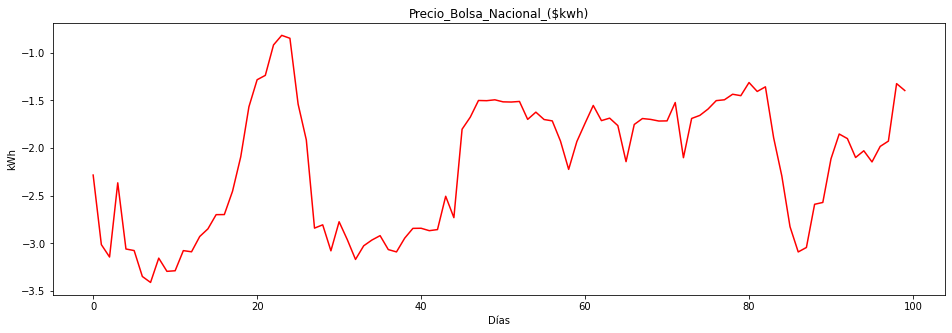

In [44]:

precalentamiento = x_transformed[0:100]
d_transformed = x_transformed[100:]
precalentamiento = precalentamiento.reshape(-1)
plot_prices(precalentamiento)

In [0]:
def sse_score_model(data):
    L = data['L']
    mu = data['mu']
    epochs = data['epochs']
    precalentamiento = data['precalentamiento']
    d_transformed = data['d_transformed']
    seed = data['seed']
    
    model = ADALINE(L)
    optimizer = get_optimizer(mu=mu)

    # precalentamiento
    np.random.seed(seed)
    tf.set_random_seed(seed)
    for _ in range(epochs):
        for t in range(L, len(precalentamiento)):
            x = precalentamiento[t-L:t]
            grads = grad(model, x, precalentamiento[t])
            optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())
            
    # entrenamiento
    SSE = []
    y_objetivo = d_transformed.reshape(-1)       
    np.random.seed(seed)
    tf.set_random_seed(seed)
    for _ in range(epochs):
        _sse = 0
        for t in range(L, len(y_objetivo)):
            x = y_objetivo[t-L:t]
            _sse += loss(model, x, y_objetivo[t])

            grads = grad(model, x, y_objetivo[t])
            optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())

        SSE.append(_sse)
        
    return SSE[-1].numpy()

Funcion para la búsqueda de los parámetros óptimos para el modelo

In [0]:
def param_search(epochs, learning_rate, L, precalentamiento, d_transformed, seed):
    score_mse = []    
    
    for epoch in epochs:
        for mu in learning_rate:
            for l in L:
                result = sse_score_model({
                    'L': l,
                    'mu': mu,
                    'epochs': epoch,
                    'precalentamiento': precalentamiento,
                    'd_transformed': d_transformed,
                    'seed': seed
                })
                params = {'epochs': epoch, 'mu': mu, 'L': l}
                score_mse.append((result, params))            
                print(f"{result:<10.2f} para {params}")
    
    return score_mse

In [0]:
import time

In [23]:
start = time.time()
result = np.array(param_search(
    epochs=[1, 15, 30, 45], 
    learning_rate=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007], 
    L=[5, 10, 15, 20, 40, 80], 
    precalentamiento=precalentamiento, 
    d_transformed=d_transformed, 
    seed=seed
))

i_min = np.argmin(result[:,0])

result[i_min]

Instructions for updating:
Colocations handled automatically by placer.
209.45     para {'epochs': 1, 'mu': 0.001, 'L': 5}
223.44     para {'epochs': 1, 'mu': 0.001, 'L': 10}
232.77     para {'epochs': 1, 'mu': 0.001, 'L': 15}
245.81     para {'epochs': 1, 'mu': 0.001, 'L': 20}
242.62     para {'epochs': 1, 'mu': 0.001, 'L': 40}
242.71     para {'epochs': 1, 'mu': 0.001, 'L': 80}
191.10     para {'epochs': 1, 'mu': 0.002, 'L': 5}
197.60     para {'epochs': 1, 'mu': 0.002, 'L': 10}
205.27     para {'epochs': 1, 'mu': 0.002, 'L': 15}
214.56     para {'epochs': 1, 'mu': 0.002, 'L': 20}
217.61     para {'epochs': 1, 'mu': 0.002, 'L': 40}
nan        para {'epochs': 1, 'mu': 0.002, 'L': 80}
182.20     para {'epochs': 1, 'mu': 0.003, 'L': 5}
187.65     para {'epochs': 1, 'mu': 0.003, 'L': 10}
195.12     para {'epochs': 1, 'mu': 0.003, 'L': 15}
203.95     para {'epochs': 1, 'mu': 0.003, 'L': 20}
7193014589067839354159925037826572288.00 para {'epochs': 1, 'mu': 0.003, 'L': 40}
nan        para {

array([146.40263, {'epochs': 45, 'mu': 0.001, 'L': 40}], dtype=object)

Entrenamiento y pronostico usando los parámetros óptimos

array([146.40263, {'epochs': 45, 'mu': 0.001, 'L': 40}], dtype=object)

L: 40 
mu: 0.001 
epochs: 45

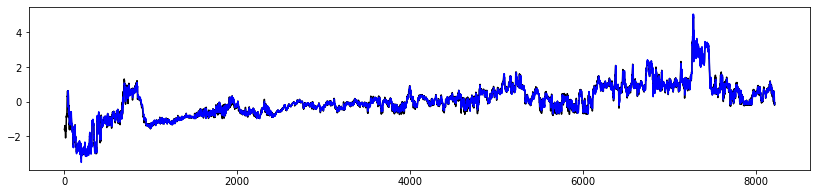

In [26]:
L = 40
epochs = 45
mu = 0.001

model = ADALINE(L)
optimizer = get_optimizer(mu=mu)

np.random.seed(seed)
tf.set_random_seed(seed)
for _ in range(epochs):
    for t in range(L, len(precalentamiento)):
        x = precalentamiento[t-L:t]
        grads = grad(model, x, precalentamiento[t])
        optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())
        
        
y_objetivo = d_transformed.reshape(-1)
y_pred = np.empty(len(y_objetivo))
y_pred[:] = np.nan

SSE = []

np.random.seed(seed)
tf.set_random_seed(seed)
for _ in range(epochs):
    _sse = 0
    for t in range(L, len(y_objetivo)):
        
        x = y_objetivo[t-L:t]
        y_pred[t] = model(x)
        _sse += loss(model, x, y_objetivo[t])
        
        grads = grad(model, x, y_objetivo[t])
        optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())
        
    SSE.append(_sse)

plot_y_vs_pred(y_objetivo, y_pred)

En negro se presenta la serie de datos original y en azul la serie de predicción.

Pronótico para precios próximos 7 días

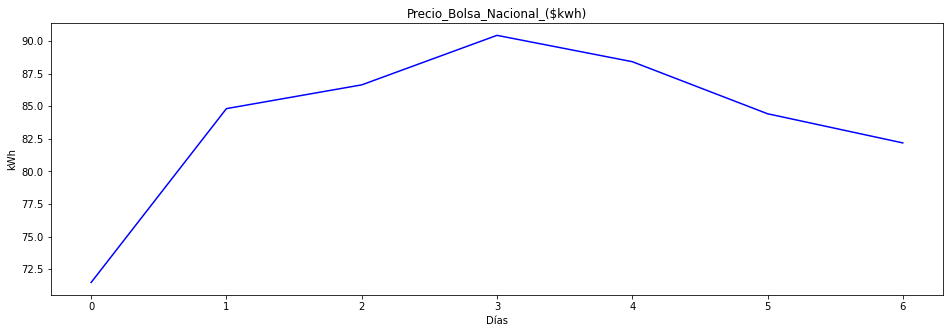

In [40]:
result_transformed = predict_n_days(model=model, data=y_objetivo, delays=L, ndays=7)
result_inverse = boxcox.inverse_transform(np.array(result_transformed[0]).reshape(-1, 1))
result_inverse[L:]

plot_prices(result_inverse[L:])